In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

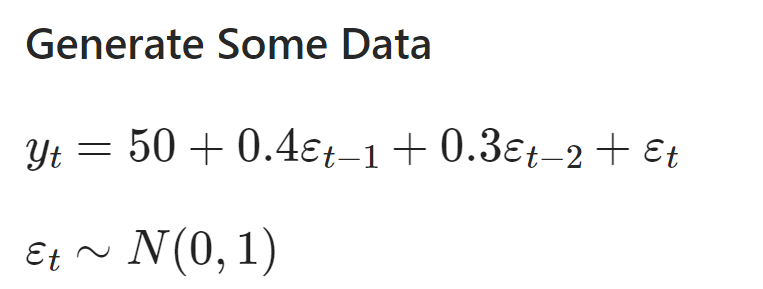

In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')

In [4]:
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [5]:
series = pd.Series(series, date_index)
series = series.asfreq(pd.infer_freq(series.index))

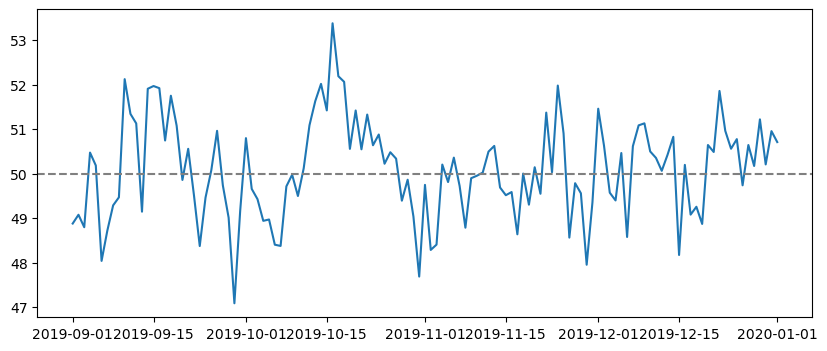

In [6]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

In [7]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

## ACF

<BarContainer object of 10 artists>

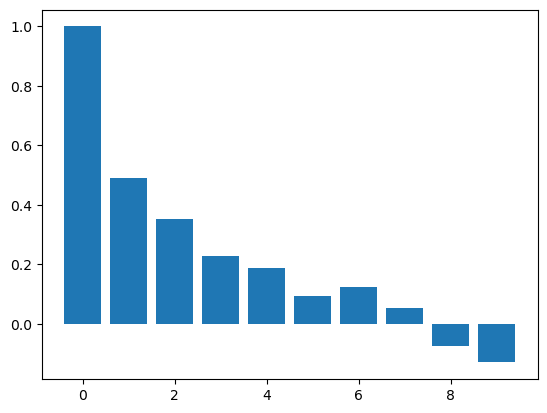

In [8]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

In [9]:
#Based on what we see, We can use MA2 Model because
#Lag 2 is the strongest before it diminishes

## PACF

<BarContainer object of 25 artists>

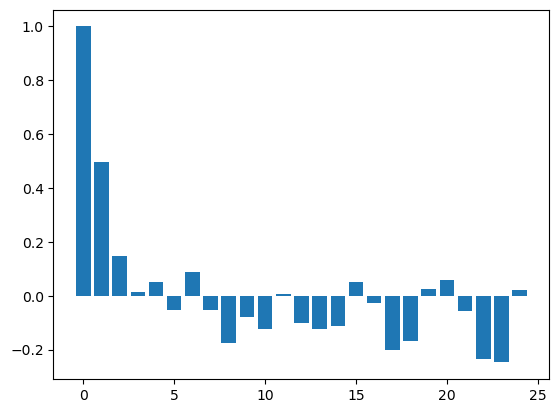

In [10]:
num_lags = 25
pacf_vals = pacf(series,nlags=num_lags)
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [11]:
#We see PACF alternating over/unde 0 and diminishing 
#over time, this also proves we should go for ACF

## Get training and testing sets

In [12]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

In [13]:
train_data = series[:train_end]
test_data = series[train_end+ timedelta(days=1):test_end]

In [14]:
test_data

2019-12-31    50.954468
2020-01-01    50.708617
Freq: D, dtype: float64

## Fit ARIMA Model

In [15]:
#create the model
model = ARIMA(train_data, order=(0,0,2))

In [16]:
#fit the model
model_fit= model.fit()

In [17]:
#summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -168.299
Date:                Tue, 25 Apr 2023   AIC                            344.597
Time:                        23:44:05   BIC                            355.781
Sample:                    09-01-2019   HQIC                           349.139
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0784      0.148    338.182      0.000      49.788      50.369
ma.L1          0.4175      0.107      3.897      0.000       0.208       0.628
ma.L2          0.2245      0.090      2.491      0.013       0.048       0.401
sigma2         0.9437      0.115      8.187      0.000       0.718       1.170
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.73   Prob(JB):                         0.80
Heteroskedasticity (H):               0.89   Skew:                            -0.09
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1. The P-Value of lag 1 and lag 2 is very low(less than 0.05) so they are statistically significant

2. Also watch for the coeff of the equation and the coeff predicted by the model. if its same then your model is good

## Predicted Model

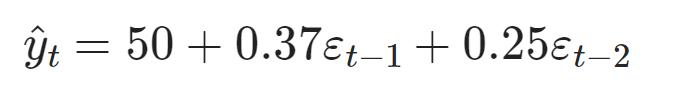

In [18]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [19]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [20]:
predictions

2019-12-31    50.187622
2020-01-01    50.015214
Freq: D, Name: predicted_mean, dtype: float64

In [21]:
residuals = test_data - predictions

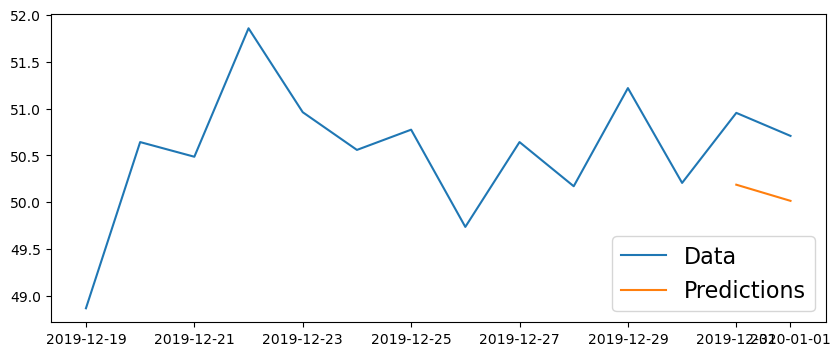

In [22]:
plt.figure(figsize=(10,4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [23]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0144


In [24]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.7310470523804417
